In [49]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from google.colab import drive

%matplotlib inline

In [2]:
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [59]:
# use absolute path when in Google Colab
# df = pd.read_csv('/content/drive/MyDrive/GitHub/pleural_effusion/Dmitrii_Utkin/_docs/Thoracic and Pleural Effusion Segmentations April 2020.csv')
df = pd.read_csv(
    "./_docs/dataset_features_and_labels_report.csv", index_col="PatientID"
)
df.describe()

,GTV1,GTV2,GTV3,GTV4,GTV5,GTV6,Tumor.Location,Effusion.Event,Right.Pleural.Effusion.Volume,RO1-Rad4.Effusion.DSC,...,Voxel.space.z,Feature.Slices,Valid.Feature,Labels.Amount,Previously.Excluded,Most.Accurate.Label,Valid.Label,First.Reviewer.Slices,Second.Reviewer.Slices,Third.Reviewer.Slices
count,401.00000,232.000000,30.000000,16.000000,8.000000,4.000000,402.000000,402.000000,56.000000,16.000000,...,402.0,402.00000,399.0,78.000000,78.000000,0.0,78.000000,78.000000,78.000000,16.000000
mean,67.10818,26.305086,10.667333,17.584375,3.612500,15.762500,2.191542,0.194030,112.749643,0.816891,...,3.0,120.81592,1.0,2.205128,0.205128,NaN,0.833333,120.564103,120.564103,112.250000
std,91.08574,42.368042,15.983865,27.519399,3.908075,21.811105,0.817897,0.395945,168.734453,0.181458,...,0.0,21.39513,0.0,0.406409,0.406409,NaN,0.375090,29.435198,29.435198,24.834116
min,0.06000,0.160000,0.220000,0.140000,0.240000,2.040000,1.000000,0.000000,2.640000,0.258910,...,3.0,75.00000,1.0,2.000000,0.000000,NaN,0.000000,82.000000,82.000000,82.000000
25%,8.07000,4.687500,1.277500,2.775000,1.357500,4.620000,1.000000,0.000000,30.520000,0.789667,...,3.0,105.25000,1.0,2.000000,0.000000,NaN,1.000000,97.500000,97.500000,94.000000
50%,34.04000,13.775000,3.470000,3.740000,2.570000,6.345000,2.000000,0.000000,59.090000,0.852917,...,3.0,124.00000,1.0,2.000000,0.000000,NaN,1.000000,121.000000,121.000000,106.000000
75%,90.54000,32.885000,13.355000,17.927500,4.270000,17.487500,3.000000,0.000000,117.325000,0.936282,...,3.0,134.00000,1.0,2.000000,0.000000,NaN,1.000000,134.000000,134.000000,134.250000
max,653.66000,400.010000,70.380000,84.970000,12.550000,48.320000,4.000000,1.000000,777.400000,0.987424,...,3.0,297.00000,1.0,3.000000,1.000000,NaN,1.000000,297.000000,297.000000,176.000000


# Cleaning up data


In [60]:
clean_df = df.drop(df[df["Previously.Excluded"] == 1].index)
clean_df.drop(
    clean_df.loc[
        (clean_df["Valid.Label"] == 0) & (clean_df["Effusion.Event"] == 1)
    ].index,
    inplace=True,
)
clean_df.dropna(axis=0, subset=["Effusion.Event"], inplace=True)
clean_df.dropna(axis=0, subset=["Valid.Feature"], inplace=True)

# Analysis


## Analysing slices


In [61]:
clean_df.loc[:, ["Feature.Slices"]].describe()

,Feature.Slices
count,377.000000
mean,120.522546
std,19.326840
min,75.000000
25%,106.000000
50%,124.000000
75%,134.000000
max,216.000000


array([[<Axes: title={'center': 'Feature.Slices'}>]], dtype=object)

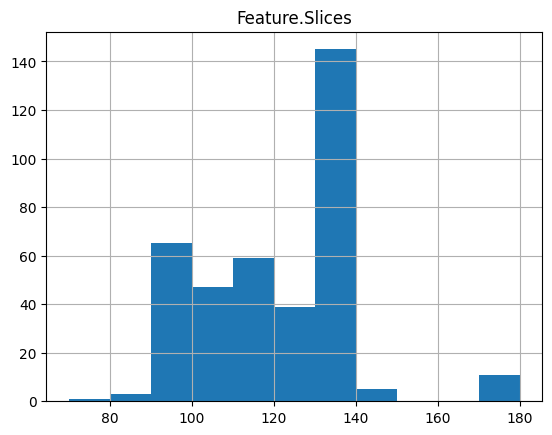

In [62]:
clean_df.loc[:, ["Feature.Slices"]].hist(bins=np.arange(70, 190, 10))

## Analysing labels


In [63]:
def get_range(range):
    return np.arange(range[0], range[1] + range[2], range[2])


def get_effusions_grouped_by_z(df, ranges):
    groups = df.groupby(["Effusion.Event", pd.cut(df.loc[:, "Feature.Slices"], ranges)])
    effusions_df = groups.size().unstack()
    summary = effusions_df.sum(axis=1)
    print(
        f"Found {summary.iloc[1]} effusion events out of {summary.iloc[1] + summary.iloc[0]} total"
    )

    return effusions_df


def get_x_labels(groupped_df):
    x_labels = []
    ranges = groupped_df.columns.values
    for idx, i in enumerate(ranges):
        if idx < len(ranges) - 1:
            x_labels.append(f"({i.left}-{ranges[idx+1].left}]")
        else:
            x_labels.append(f"({i.left}-{i.right}]")

    return x_labels


def plot_effusions_by_z(df, range):
    df = df.loc[(df["Feature.Slices"] > range[0]) & (df["Feature.Slices"] <= range[1])]
    range = get_range(range)
    print(f"Data for range {range[0]}-{range[-1]}")
    groupped_df = get_effusions_grouped_by_z(df, range)
    x_labels = get_x_labels(groupped_df)
    x_axis = np.arange(len(x_labels))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        x_axis + 0.2, groupped_df.iloc[0, :], width=0.4, label="Without effusion"
    )
    plt.bar_label(bars)
    bars = plt.bar(
        x_axis - 0.2, groupped_df.iloc[1, :], width=0.4, label="With effusion"
    )
    plt.bar_label(bars)

    plt.xticks(x_axis, x_labels, rotation=45)
    plt.xlabel("'Feature.Slices' Groups")
    plt.ylabel("Number of labels")
    plt.title("Number of labels in 'Feature.Slices'")
    plt.legend()
    plt.show()
    print("=" * 10)

Data for range 80-180
Found 54 effusion events out of 374 total


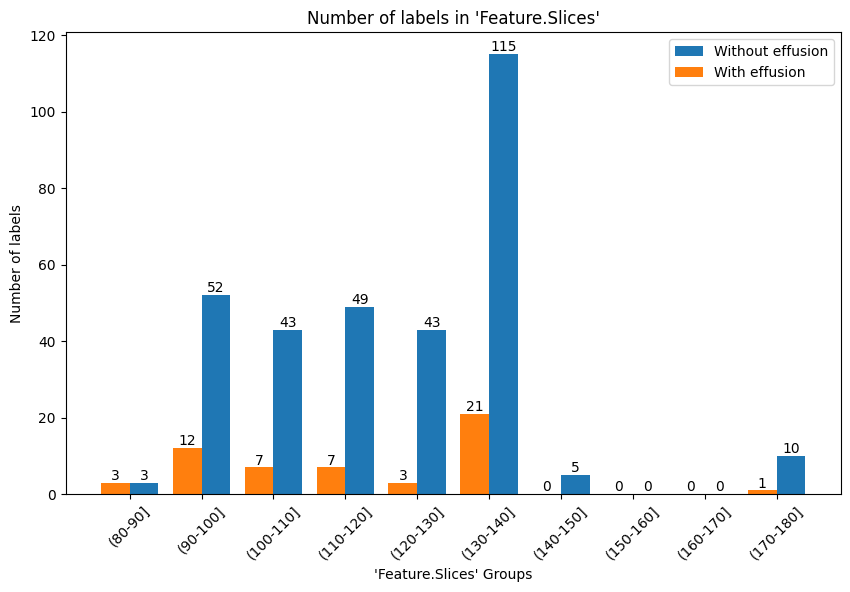

Data for range 80-140
Found 53 effusion events out of 358 total


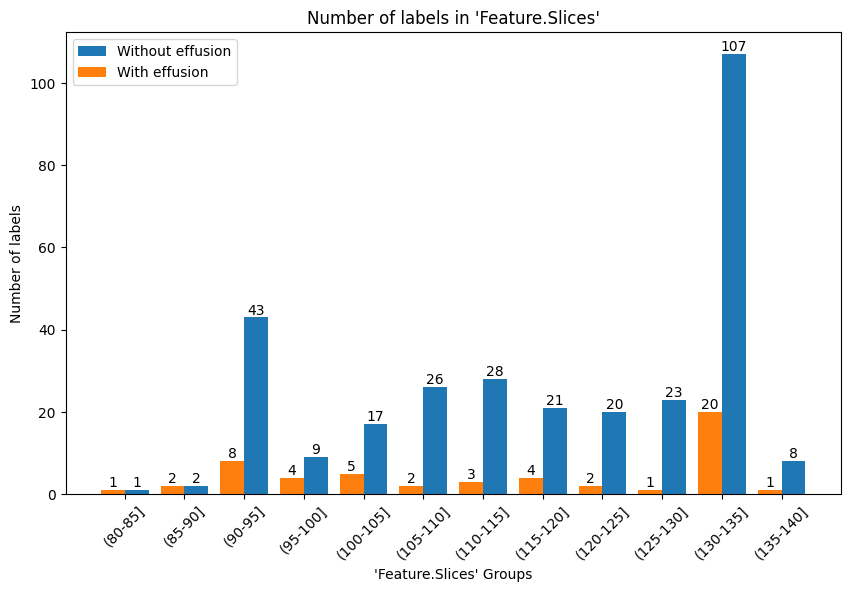

[None, None]

In [64]:
ranges = [(80, 180, 10), (80, 140, 5)]
[plot_effusions_by_z(clean_df, x) for x in ranges]

Data for range 80-90
Found 3 effusion events out of 6 total


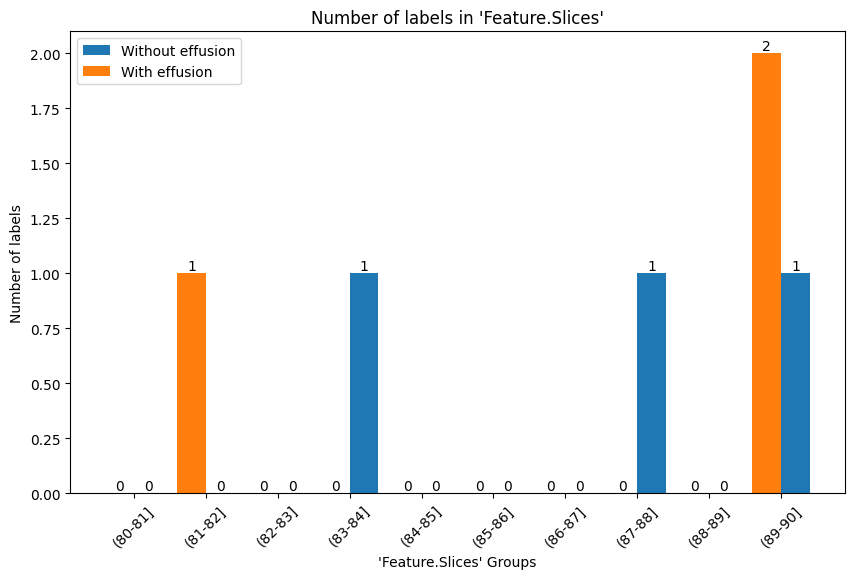

Data for range 135-140
Found 1 effusion events out of 9 total


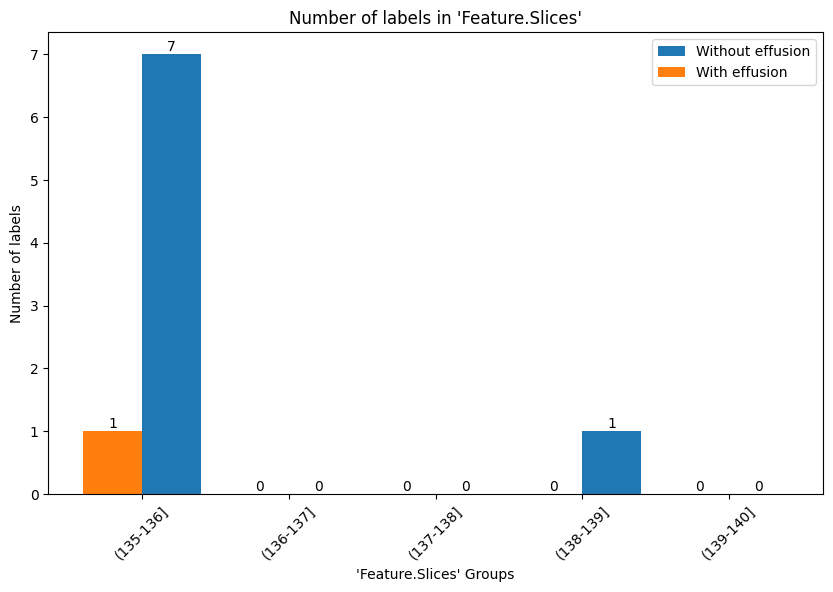

[None, None]

In [65]:
edge_ranges = [(80, 90, 1), (135, 140, 1)]
[plot_effusions_by_z(clean_df, x) for x in edge_ranges]

# Suggestions


1. Removing features with Dim.z > 136 and Dim.z < 88


In [67]:
cropped_df = clean_df.drop(
    clean_df.loc[
        (clean_df["Feature.Slices"] > 136) | (clean_df["Feature.Slices"] < 88)
    ].index,
    axis=0,
)

In [68]:
print(len(cropped_df.loc[(clean_df["Effusion.Event"] == 1)]), len(cropped_df))

52 355


In [73]:
summary = cropped_df["Feature.Slices"].describe()
summary

count    355.000000
mean     118.338028
std       15.437082
min       88.000000
25%      105.000000
50%      122.000000
75%      134.000000
max      136.000000
Name: Feature.Slices, dtype: float64

In [74]:
max_slices_to_add = summary["max"] - summary["min"]
print(max_slices_to_add)

48.0


In [49]:
cropped_df.loc[:, ["Effusion.Event"]].aggregate(["sum", "count"])

,Effusion.Event
sum,49.0
count,354.0


2. Padding features and labels with slices up to z = 136


3. Choosing most accurate labels
